In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from scipy import stats    
import math
from sklearn.decomposition import PCA
from scipy.interpolate import Rbf
import scipy.cluster.hierarchy as shc
from scipy import stats
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
'''LandKreis reported cases with gender and age levels'''
landkreise=pd.read_csv("./RKI_COVID19.csv")[["Landkreis", "Altersgruppe", "Geschlecht","AnzahlFall", "AnzahlTodesfall"]]
landkreise_gl=landkreise.groupby(["Landkreis", "Geschlecht"]).sum().reset_index("Landkreis").drop("unbekannt").reset_index("Geschlecht")#.plot.bar(subplots=True)
mask_male=(landkreise_gl["Geschlecht"] == "M")
mask_female=(landkreise_gl["Geschlecht"] == "W")
stats.ttest_ind(landkreise_gl.loc[mask_male,"AnzahlFall"], landkreise_gl.loc[mask_female,"AnzahlFall"])

Ttest_indResult(statistic=1.8978903759440033, pvalue=0.05807206841171554)

In [3]:

ltp_mask=(landkreise["Geschlecht"] != "unbekannt") & (landkreise["Altersgruppe"] != "unbekannt") 
landkreise_fall=landkreise.loc[ltp_mask,:].pivot_table(values=["AnzahlFall"], index="Landkreis", columns=["Geschlecht", "Altersgruppe"], aggfunc="sum").fillna(0)
sig_mask=(landkreise_fall.apply(lambda x: stats.ttest_ind(x[("AnzahlFall", "M")], x[("AnzahlFall", "W")])[1], axis=1) <= 0.05)
landkreise_fall.loc[sig_mask,:]


AnzahlFall                                                       \
Geschlecht             M                                            W           
Altersgruppe     A00-A04 A05-A14 A15-A34 A35-A59 A60-A79 A80+ A00-A04 A05-A14   
Landkreis                                                                       
LK Nordhausen        0.0     0.0     1.0     1.0     1.0  0.0     0.0     0.0   

                                            
Geschlecht                                  
Altersgruppe  A15-A34 A35-A59 A60-A79 A80+  
Landkreis                                   
LK Nordhausen     0.0     0.0     0.0  0.0

In [4]:
stats.ttest_ind(landkreise_gl.loc[mask_male,"AnzahlTodesfall"], landkreise_gl.loc[mask_female,"AnzahlTodesfall"])[1]

0.26916082233475025

In [10]:
bundeslaender=pd.read_csv("./RKI_Corona_Bundesländer.csv").drop(["OBJECTID_1", "LAN_ew_AGS", "OBJECTID", "Aktualisierung", "AGS_TXT", "GlobalID"], axis=1)
bundeslaender["LAN_ew_BEZ"]=bundeslaender["LAN_ew_BEZ"].replace({'Land': 0, 'Freie und Hansestadt': 2, 'Freistaat':1, 'Freie Hansestadt': 2})
bundeslaender[["LAN_ew_EWZ", "Fallzahl", "faelle_100000_EW", "Shape__Area","Shape__Length"]]=pd.DataFrame(np.log10(bundeslaender[["LAN_ew_EWZ", "Fallzahl", "faelle_100000_EW", "Shape__Area","Shape__Length"]]),columns=["LAN_ew_EWZ", "Fallzahl", "faelle_100000_EW", "Shape__Area","Shape__Length"])
bundeslaender=bundeslaender.set_index("LAN_ew_GEN")
bundeslaender.head()


,LAN_ew_BEZ,LAN_ew_EWZ,Fallzahl,faelle_100000_EW,Shape__Area,Shape__Length,Death
LAN_ew_GEN,,,,,,,
Schleswig-Holstein,0,6.460871,2.540329,1.079459,10.660271,6.459618,1
Hamburg,2,6.262590,2.940516,1.677927,9.320021,5.622007,0
Niedersachsen,0,6.901064,3.115943,1.214879,11.113889,6.603035,1
Bremen,2,5.833168,2.217484,1.384316,9.048891,5.525974,0
Nordrhein-Westfalen,0,7.253147,3.549616,1.296469,10.943640,6.423028,6


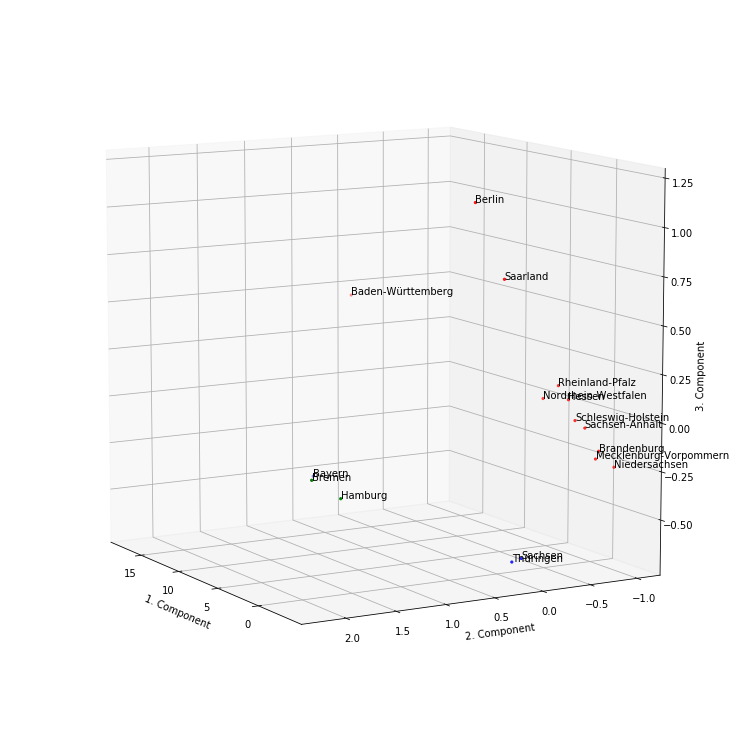

In [11]:
pca = PCA(n_components=3)
vecs = pca.fit_transform(bundeslaender)

fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
color_dict = {0:"r", 1:"b", 2:"g"}
ls_color = [color_dict[item] for item in bundeslaender["LAN_ew_BEZ"]]
ax.scatter(vecs[:,0], vecs[:,1], vecs[:,2], marker=".", facecolor=ls_color)
for i in range(len(bundeslaender.index)):
    ax.text(vecs[i,0], vecs[i,1], vecs[i,2], bundeslaender.index[i])
ax.set_xlabel('1. Component')
ax.set_ylabel('2. Component')
ax.set_zlabel('3. Component')
ax.view_init(elev=10, azim=150)

plt.show()

Text(0,0.5,'2. Component')

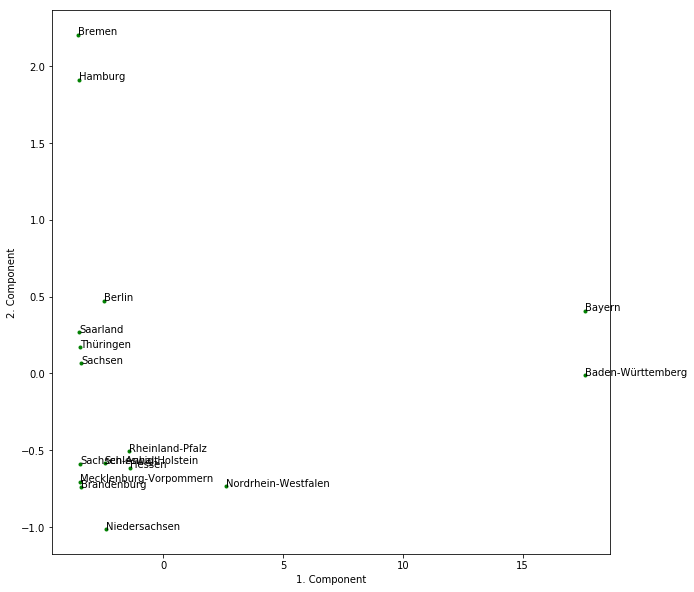

In [26]:
plt.figure(figsize=(10, 10))
ax=plt.subplot()
ax.plot(vecs[:,0], vecs[:,1], "g.")
for i in range(len(bundeslaender.index)):
    ax.annotate(bundeslaender.index[i], (vecs[i,0], vecs[i,1]))
plt.xlabel("1. Component")
plt.ylabel("2. Component")

In [148]:
for i in range(len(vecs[0,:])):
    print(pd.DataFrame(vecs, index=bundeslaender.index).sort_values(i, ascending=False).iloc[0:3, i])

LAN_ew_GEN
Bayern                 17.604587
Baden-Württemberg      17.593438
Nordrhein-Westfalen     2.643224
Name: 0, dtype: float64
LAN_ew_GEN
Bremen     2.203800
Hamburg    1.912982
Berlin     0.471929
Name: 1, dtype: float64
LAN_ew_GEN
Berlin               1.165660
Saarland             0.785763
Baden-Württemberg    0.444400
Name: 2, dtype: float64


In [151]:
for i in range(len(vecs1[0,:])):
    print(pd.DataFrame(vecs1, index=bundeslaender.columns).sort_values(i, ascending=False).iloc[0:3, i])

Shape__Area      24.389328
LAN_ew_EWZ        8.773214
Shape__Length     7.601139
Name: 0, dtype: float64
Death          21.922081
Shape__Area     0.004849
LAN_ew_EWZ     -2.256761
Name: 1, dtype: float64
LAN_ew_BEZ     1.543787
Shape__Area    0.479857
Death          0.066722
Name: 2, dtype: float64


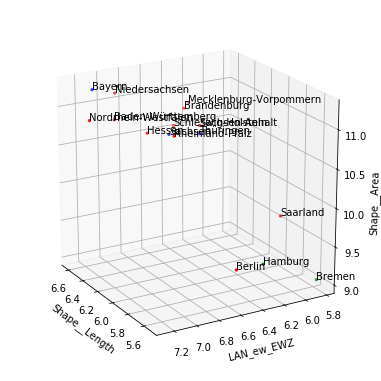

In [12]:
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig)

ax.scatter(bundeslaender["Shape__Length"], bundeslaender["LAN_ew_EWZ"], bundeslaender["Shape__Area"], marker=".", facecolor=ls_color)
for i in range(len(bundeslaender["Shape__Length"])):
    ax.text(bundeslaender["Shape__Length"][i], bundeslaender["LAN_ew_EWZ"][i], bundeslaender["Shape__Area"][i], bundeslaender.index[i])
ax.set_xlabel("Shape__Length")
ax.set_ylabel("LAN_ew_EWZ")
ax.set_zlabel("Shape__Area")
ax.view_init(elev=20, azim=150)

plt.show()

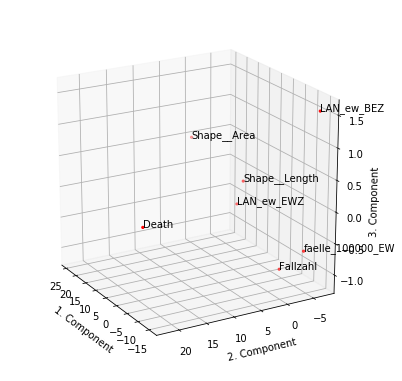

In [18]:
pca = PCA(n_components=3)
vecs1 = pca.fit_transform(bundeslaender.T)
fig = plt.figure(figsize=(5, 5))
ax = Axes3D(fig)

ax.scatter(vecs1[:,0], vecs1[:,1], vecs1[:,2], marker=".", facecolor="r")
for i in range(len(bundeslaender.columns)):
    ax.text(vecs1[i,0], vecs1[i,1], vecs1[i,2], bundeslaender.columns[i])
ax.set_xlabel("1. Component")
ax.set_ylabel("2. Component")
ax.set_zlabel("3. Component")
ax.view_init(elev=20, azim=150)

plt.show()

Text(0,0.5,'2. Component')

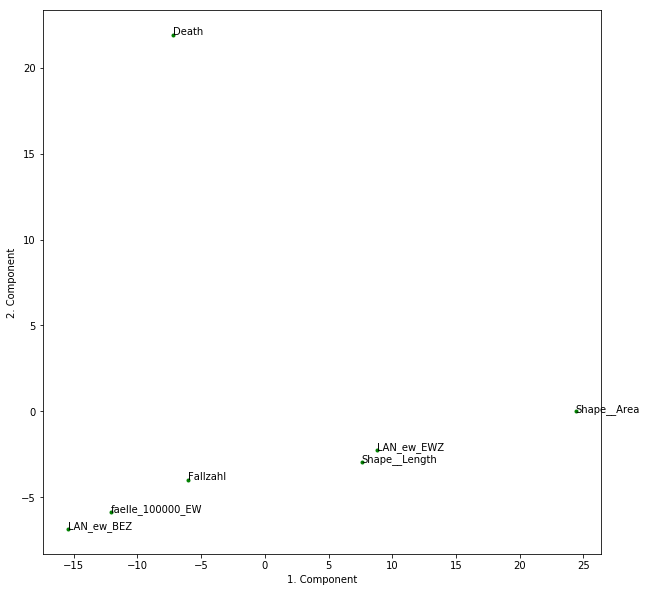

In [28]:
plt.figure(figsize=(10, 10))
ax=plt.subplot()
ax.plot(vecs1[:,0], vecs1[:,1], "g.")
for i in range(len(bundeslaender.columns)):
    ax.annotate(bundeslaender.columns[i], (vecs1[i,0], vecs1[i,1]))
plt.xlabel("1. Component")
plt.ylabel("2. Component")